# AutoMM Detection - Quick Start on a Tiny COCO Format Dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/object_detection/quick_start/quick_start_coco.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/object_detection/quick_start/quick_start_coco.ipynb)



In this section, our goal is to fast finetune a pretrained model on a small dataset in COCO format,
and evaluate on its test set. Both training and test sets are in COCO format.
See [Convert Data to COCO Format](../data_preparation/convert_data_to_coco_format.ipynb) for how to convert other datasets to COCO format.

## Setting up the imports
To start, let's import MultiModalPredictor:

In [ ]:
!pip install autogluon.multimodal

Make sure `mmcv` and `mmdet` are installed:

In [ ]:
!mim install "mmcv==2.1.0"
!pip install "mmdet==3.2.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.3.0/index.html


In [ ]:
!pip install autogluon
!pip install torch torchvision torchaudio transformers

In [ ]:
!pip uninstall torch torchaudio -y
!pip install torch torchvision torchaudio

Found existing installation: torch 2.3.1
Uninstalling torch-2.3.1:
  Successfully uninstalled torch-2.3.1
Found existing installation: torchaudio 2.3.1
Uninstalling torchaudio-2.3.1:
  Successfully uninstalled torchaudio-2.3.1
  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchaudio-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached triton-3.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.3 kB)
  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached torchaudio-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
Using cached torc

In [ ]:
!pip install autogluon --upgrade

In [ ]:
from autogluon.multimodal import MultiModalPredictor

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


And also import some other packages that will be used in this tutorial:

In [ ]:
import os
import time

from autogluon.core.utils.loaders import load_zip

## Downloading Data
We have the sample dataset ready in the cloud. Let's download it:

In [ ]:
zip_file = "https://automl-mm-bench.s3.amazonaws.com/object_detection_dataset/tiny_motorbike_coco.zip"
download_dir = "./tiny_motorbike_coco"

load_zip.unzip(zip_file, unzip_dir=download_dir)
data_dir = os.path.join(download_dir, "tiny_motorbike")
train_path = os.path.join(data_dir, "Annotations", "trainval_cocoformat.json")
test_path = os.path.join(data_dir, "Annotations", "test_cocoformat.json")

While using COCO format dataset, the input is the json annotation file of the dataset split.
In this example, `trainval_cocoformat.json` is the annotation file of the train-and-validate split,
and `test_cocoformat.json` is the annotation file of the test split.

## Creating the MultiModalPredictor
We select the `"medium_quality"` presets, which uses a YOLOX-large model pretrained on COCO dataset. This preset is fast to finetune or inference,
and easy to deploy. We also provide presets `"high_quality"` with a DINO-Resnet50 model and `"best quality"` with a DINO-SwinL model, with much higher performance but also slower and with higher GPU memory usage.

In [ ]:
presets = "medium_quality"

We create the MultiModalPredictor with selected presets.
We need to specify the problem_type to `"object_detection"`,
and also provide a `sample_data_path` for the predictor to infer the catgories of the dataset.
Here we provide the `train_path`, and it also works using any other split of this dataset.
And we also provide a `path` to save the predictor.
It will be saved to a automatically generated directory with timestamp under `AutogluonModels` if `path` is not specified.

In [ ]:
# Init predictor
import uuid

model_path = f"./tmp/{uuid.uuid4().hex}-quick_start_tutorial_temp_save"

predictor = MultiModalPredictor(
    problem_type="object_detection",
    sample_data_path=train_path,
    presets=presets,
    path=model_path,
)

## Finetuning the Model

Learning rate, number of epochs, and batch_size are included in the presets, and thus no need to specify.
Note that we use a two-stage learning rate option during finetuning by default,
and the model head will have 100x learning rate.
Using a two-stage learning rate with high learning rate only on head layers makes
the model converge faster during finetuning. It usually gives better performance as well,
especially on small datasets with hundreds or thousands of images.
We also compute the time of the fit process here for better understanding the speed.
We run it on a g4.2xlarge EC2 machine on AWS,
and part of the command outputs are shown below:

In [ ]:
start = time.time()
predictor.fit(train_path)  # Fit
train_end = time.time()

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.3.1+cu121
CUDA Version:       12.1
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   WARNING, an exception (FileNotFoundError) occurred while attempting to get available disk space. Consider opening a GitHub Issue.
Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/tmp/ab4d9ca096cb44cab41b7431a355ece5-quick_start_tutorial_temp_save
    ```

INFO: Seed set to 0


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loads checkpoint by local backend from path: yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth


GPU Count: 1
GPU Count to be Used: 1
GPU 0 Name: Tesla T4
GPU 0 Memory: 0.25GB/15.0GB (Used/Total)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 256, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.0.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([10]).
size mismatch for bbox_head.multi_level_conv_cls.1.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 256, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([10]).
size mismatch for bbox_head.multi_level_conv_cls.2.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 256, 1, 1]).
size mismatch for bbox_head.multi_level_conv

INFO: 
  | Name              | Type                             | Params | Mode 
-------------------------------------------------------------------------------
0 | model             | MMDetAutoModelForObjectDetection | 54.2 M | train
1 | validation_metric | MeanAveragePrecision             | 0      | train
-------------------------------------------------------------------------------
54.2 M    Trainable params
0         Non-trainable params
54.2 M    Total params
216.620   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 15: 'val_map' reached 0.33796 (best 0.33796), saving model to '/content/tmp/ab4d9ca096cb44cab41b7431a355ece5-quick_start_tutorial_temp_save/epoch=2-step=15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 30: 'val_map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 45: 'val_map' reached 0.38069 (best 0.38069), saving model to '/content/tmp/ab4d9ca096cb44cab41b7431a355ece5-quick_start_tutorial_temp_save/epoch=8-step=45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 60: 'val_map' reached 0.41595 (best 0.41595), saving model to '/content/tmp/ab4d9ca096cb44cab41b7431a355ece5-quick_start_tutorial_temp_save/epoch=11-step=60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 75: 'val_map' reached 0.45463 (best 0.45463), saving model to '/content/tmp/ab4d9ca096cb44cab41b7431a355ece5-quick_start_tutorial_temp_save/epoch=14-step=75.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 90: 'val_map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 105: 'val_map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 120: 'val_map' reached 0.46099 (best 0.46099), saving model to '/content/tmp/ab4d9ca096cb44cab41b7431a355ece5-quick_start_tutorial_temp_save/epoch=23-step=120.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 26, global step 135: 'val_map' reached 0.47348 (best 0.47348), saving model to '/content/tmp/ab4d9ca096cb44cab41b7431a355ece5-quick_start_tutorial_temp_save/epoch=26-step=135.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 29, global step 150: 'val_map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 32, global step 165: 'val_map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 35, global step 180: 'val_map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 38, global step 195: 'val_map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 41, global step 210: 'val_map' was not in top 1
AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/tmp/ab4d9ca096cb44cab41b7431a355ece5-quick_start_tutorial_temp_save")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




Notice that at the end of each progress bar, if the checkpoint at current stage is saved,
it prints the model's save path.
In this example, it's `./quick_start_tutorial_temp_save`.

Print out the time and we can see that it's fast!

In [ ]:
print("This finetuning takes %.2f seconds." % (train_end - start))

This finetuning takes 924.49 seconds.


## Evaluation

To evaluate the model we just trained, run following code.

And the evaluation results are shown in command line output.
The first line is mAP in COCO standard, and the second line is mAP in VOC standard (or mAP50).
For more details about these metrics, see [COCO's evaluation guideline](https://cocodataset.org/#detection-eval).
Note that for presenting a fast finetuning we use presets "medium_quality",
you could get better result on this dataset by simply using "high_quality" or "best_quality" presets,
or customize your own model and hyperparameter settings: [Customization](../../advanced_topics/customization.ipynb), and some other examples at [Fast Fine-tune Coco](../finetune/detection_fast_finetune_coco) or [High Performance Fine-tune Coco](../finetune/detection_high_performance_finetune_coco).

In [ ]:
predictor.evaluate(test_path)
eval_end = time.time()

Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Predicting: |          | 0/? [00:00<?, ?it/s]

A new predictor save path is created. This is to prevent you to overwrite previous predictor saved here. You could check current save path at predictor._save_path. If you still want to use this path, set resume=True
No path specified. Models will be saved in: "AutogluonModels/ag-20240926_023505"


saving file at /content/AutogluonModels/ag-20240926_023505/object_detection_result_cache.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=  

Print out the evaluation time:

In [ ]:
print("The evaluation takes %.2f seconds." % (eval_end - train_end))

The evaluation takes 61.02 seconds.


We can load a new predictor with previous save_path,
and we can also reset the number of GPUs to use if not all the devices are available:

In [ ]:
# Load and reset num_gpus
new_predictor = MultiModalPredictor.load(model_path)
new_predictor.set_num_gpus(1)

Load pretrained checkpoint: /content/tmp/ab4d9ca096cb44cab41b7431a355ece5-quick_start_tutorial_temp_save/model.ckpt


Evaluating the new predictor gives us exactly the same result:

In [ ]:
# Evaluate new predictor
new_predictor.evaluate(test_path)

Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Predicting: |          | 0/? [00:00<?, ?it/s]

A new predictor save path is created. This is to prevent you to overwrite previous predictor saved here. You could check current save path at predictor._save_path. If you still want to use this path, set resume=True
No path specified. Models will be saved in: "AutogluonModels/ag-20240926_023517"


saving file at /content/AutogluonModels/ag-20240926_023517/object_detection_result_cache.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=  

{'map': 0.3641261275188341,
 'mean_average_precision': 0.3641261275188341,
 'map_50': 0.5249143462047373,
 'map_75': 0.39209779597082756,
 'map_small': 0.2221366354228851,
 'map_medium': 0.4459716681084122,
 'map_large': 0.7547044943494515,
 'mar_1': 0.24885365280714114,
 'mar_10': 0.4130082217524078,
 'mar_100': 0.420041813483674,
 'mar_small': 0.36375,
 'mar_medium': 0.48365079365079366,
 'mar_large': 0.7991632928475033}

For how to set the hyperparameters and finetune the model with higher performance,
see [AutoMM Detection - High Performance Finetune on COCO Format Dataset](../finetune/detection_high_performance_finetune_coco.ipynb).

## Inference
Now that we have gone through the model setup, finetuning, and evaluation, this section details the inference.
Specifically, we layout the steps for using the model to make predictions and visualize the results.

To run inference on the entire test set, perform:

In [ ]:
pred = predictor.predict(test_path)
print(pred)

Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Predicting: |          | 0/? [00:00<?, ?it/s]

                                                image  \
0   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
1   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
2   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
3   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
4   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
5   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
6   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
7   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
8   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
9   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
10  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
11  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
12  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
13  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
14  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
15  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
16  ./tiny_motorbike_coco/tiny_

The output `pred` is a `pandas` `DataFrame` that has two columns, `image` and `bboxes`.

In `image`, each row contains the image path

In `bboxes`, each row is a list of dictionaries, each one representing a bounding box: `{"class": <predicted_class_name>, "bbox": [x1, y1, x2, y2], "score": <confidence_score>}`

Note that, by default, the `predictor.predict` does not save the detection results into a file.

To run inference and save results, run the following:

In [ ]:
pred = predictor.predict(test_path, save_results=True)

Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Predicting: |          | 0/? [00:00<?, ?it/s]

A new predictor save path is created. This is to prevent you to overwrite previous predictor saved here. You could check current save path at predictor._save_path. If you still want to use this path, set resume=True
No path specified. Models will be saved in: "AutogluonModels/ag-20240926_023530"
Saved detection results to /content/AutogluonModels/ag-20240926_023530/result.txt


Here, we save `pred` into a `.txt` file, which exactly follows the same layout as in `pred`.
You can use a predictor initialized in any way (i.e. finetuned predictor, predictor with pretrained model, etc.).

## Visualizing Results
To run visualizations, ensure that you have `opencv` installed. If you haven't already, install `opencv` by running

In [ ]:
!pip install opencv-python

To visualize the detection bounding boxes, run the following:

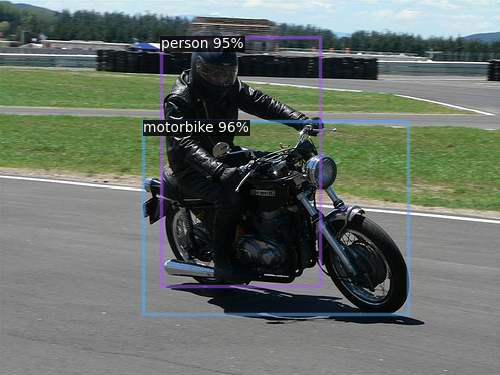

In [ ]:
from autogluon.multimodal.utils import ObjectDetectionVisualizer

conf_threshold = 0.4  # Specify a confidence threshold to filter out unwanted boxes
image_result = pred.iloc[30]

img_path = image_result.image  # Select an image to visualize

visualizer = ObjectDetectionVisualizer(img_path)  # Initialize the Visualizer
out = visualizer.draw_instance_predictions(image_result, conf_threshold=conf_threshold)  # Draw detections
visualized = out.get_image()  # Get the visualized image

from PIL import Image
from IPython.display import display
img = Image.fromarray(visualized, 'RGB')
display(img)

## Testing on Your Own Data
You can also predict on your own images with various input format. The follow is an example:

Download the example image:

In [ ]:
from autogluon.multimodal import download
image_url = "https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/detection/street_small.jpg"
test_image = download(image_url)

Run inference on data in a json file of COCO format (See [Convert Data to COCO Format](../data_preparation/convert_data_to_coco_format.ipynb) for more details about COCO format). Note that since the root is by default the parent folder of the annotation file, here we put the annotation file in a folder:

In [ ]:
import json
import os

# create a input file for demo
data = {"images": [{"id": 0, "width": -1, "height": -1, "file_name": test_image}], "categories": []}

# Check if the directory exists before trying to create it
if not os.path.exists("input_data_for_demo"):
    os.mkdir("input_data_for_demo")

input_file = "input_data_for_demo/demo_annotation.json"
with open(input_file, "w+") as f:
    json.dump(data, f)

pred_test_image = predictor.predict(input_file)
print(pred_test_image)

Using default root folder: input_data_for_demo/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Predicting: |          | 0/? [00:00<?, ?it/s]

                                     image  \
0  input_data_for_demo/../street_small.jpg   

                                              bboxes  
0  [{'class': 'person', 'class_id': 8, 'bbox': [2...  


Run inference on data in a list of image file names:

In [ ]:
pred_test_image = predictor.predict([test_image])
print(pred_test_image)

Predicting: |          | 0/? [00:00<?, ?it/s]

              image                                             bboxes
0  street_small.jpg  [{'class': 'person', 'class_id': 8, 'bbox': [2...


## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../../advanced_topics/customization.ipynb).

## Citation

```
@article{DBLP:journals/corr/abs-2107-08430,
  author    = {Zheng Ge and
               Songtao Liu and
               Feng Wang and
               Zeming Li and
               Jian Sun},
  title     = {{YOLOX:} Exceeding {YOLO} Series in 2021},
  journal   = {CoRR},
  volume    = {abs/2107.08430},
  year      = {2021},
  url       = {https://arxiv.org/abs/2107.08430},
  eprinttype = {arXiv},
  eprint    = {2107.08430},
  timestamp = {Tue, 05 Apr 2022 14:09:44 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/abs-2107-08430.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org},
}
```
